In [48]:
from generation import generate_from_total_pdf
from distributions import total_cdf, total_model, background_model
from hypothesis_test import NP_test
import matplotlib.pyplot as plt
from pytest import approx

true_params = {'f': 0.1, 'lam': 0.5, 'mu': 5.28, 'sigma': 0.018}

N_events = 1000
dataset = generate_from_total_pdf(N_events)

Generated 1000 events in 0.001813s


In [49]:
import numpy as np
from scipy.stats import chi2, norm
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL, BinnedNLL

In [50]:
# from hypothesis_test import NP_test

# NP_test(dataset, total_cdf, 1000, true_params)

In [51]:
dataset = dataset
cdf = total_cdf
starting_params = true_params

In [52]:
# choosing the number of bins
bins = int(np.sqrt(len(dataset)))

In [53]:
# Bin the dataset
bin_density, bin_edges = np.histogram(dataset, bins=bins, density=True)

# Calculate bin midpoints
midpoints = 0.5 * (bin_edges[:-1] + bin_edges[1:])

In [54]:
# Cost function is binned negative log likelihood
binned_nll = BinnedNLL(bin_density, bin_edges, cdf)

# Minimisation object
mi = Minuit(binned_nll, **starting_params)

#####################################
# Run the fit for the alternate hypothesis
#####################################

# Run minimisation and Hesse algorithm
mi.migrad()
mi.hesse()

# Parameter values for total model fit
h1_params = list(mi.values)

# Negative log likelihood for the dataset given the alternate hypothesis 
h1_nll = mi.fval

print(mi)

#####################################
# Run the fit for the null hypothesis
#####################################

# Set parameters such that we fit background-only model
mi.values['f'] = 0
mi.fixed['f'] = True
mi.fixed['mu'] = True
mi.fixed['sigma'] = True

# Run minimisation and Hesse algorithm
mi.migrad()
mi.hesse()

# Parameter values for background-only fit
h0_params = list(mi.values)

# negative log likelihood for the dataset given the null hypothesis 
h0_nll = mi.fval

print(mi)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.513 (chi2/ndof = 0.1)    │              Nfcn = 94               │
│ EDM = 3.77e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

In [55]:
h1_params

[0.07741492589782303,
 0.6196235397598309,
 5.2800993010133705,
 0.014703339961620262]

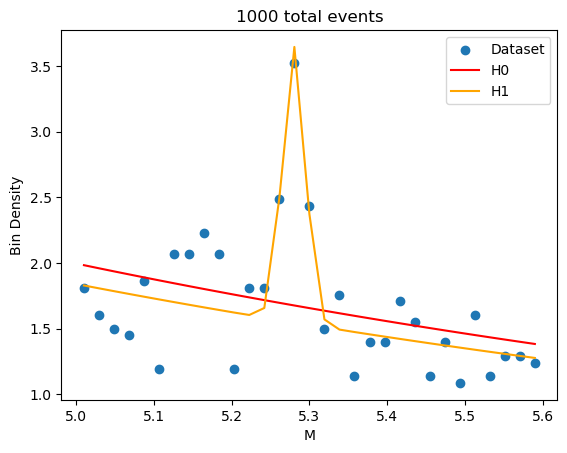

In [56]:
fig, ax = plt.subplots()

# Plotting bin count vs midpoints
ax.scatter(midpoints, bin_density, label='Dataset', marker='o')
# ax.plot(midpoints, total_model(midpoints, **true_params), label='True model', color='red')
ax.plot(midpoints, total_model(midpoints, *h0_params), label='H0', color='red')
ax.plot(midpoints, total_model(midpoints, *h1_params), label='H1', color='orange')

ax.set_xlabel('M')
ax.set_ylabel('Bin Density')
ax.set_title(f'{N_events} total events')

ax.legend()

In [57]:
T = 2*(h0_nll - h1_nll) # test statistic
k = 1               # degrees of freedom

# Calculate p value
p_value = 1 - chi2.cdf(T, k) 

# Calculate significance (it is a one-sided test)
Z = norm.ppf(1 - p_value)

# Alternate way to calculate Z for a one-sided test
alternate_Z = np.sqrt(chi2.ppf(1 - 2*p_value,1))
assert(Z == approx(alternate_Z))

# If we get a significance greater than 5, we have 'discovered' the signal
if Z >= 5:
    discovery = True
else:
    discovery = False

In [58]:
Z

1.9251688299000747

In [59]:
norm.ppf(1 - p_value)

1.9251688299000747